# PM10 Monitoring using CAMS data
Atmospheric aerosol measurements are performed from sensors based on in-situ stations and on board satellites. Sensors at the earth surface collect particulate matters or retrieve the information from light scattering and absorption using active and passive sensors. The data collected from in-situ stations are used as input to numerical models to provide information on areas that lack direct observations. Air quality forecast use, beyond the observations, information about the height of the boundary layer, the wind field, the topography, the land cover. Examples of satellites that provide data products for aerosols are

* Copernicus Sentinel-3 ([SLSTR instrument](https://www.eumetsat.int/S3-AOD))  
* Copericus Sentinel 5-p ([TROPOMI Products and Algorithms](https://sentinels.copernicus.eu/web/sentinel/technical-guides/sentinel-5p/products-algorithms))  
* NASA Terra ([MODIS](https://atmosphere-imager.gsfc.nasa.gov/products/aerosol))
* ESA [EarthCARE](https://earth.esa.int/eogateway/missions/earthcare)

The Copernicus Sentinel 5-p provides data about the UV Aerosol Index and the Aerosol Layer Height. For more info see the  and the Algorithm Theoretical Basis Documents (ATDB), ATDB-AI and ATDB-LH respectively.  

The Copernicus Atmosphere Monitoring Service (CAMS) provides [datasets](https://ads.atmosphere.copernicus.eu/cdsapp#!/dataset/cams-europe-air-quality-forecasts?tab=overview) about air quality observations and forecasts. The forecasts are based on a data assimilation process and numerical models updated daily using new observations. The numerical models are developed by several research institutes. The vertical coverage of the data is: surface, 50m, 100m, 250m, 500m, 750m, 1000m, 2000m, 3000m, 5000m. The horizontal spatial resolution is 0.1° (i.e. 10 km). The vertical profile is retrieved from the aerosol optical depth (AOD), the scattering and absorption data at different heights, and a mathematical model of the vertical distribution of the particulate matter.

The purpose of this notebook is to compare the pm10 measurements from in-situ stations in the arctic region and the data from the CAMS ensemble model over the same area.

In [1]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import cdsapi
import warnings
warnings.filterwarnings('ignore')
from platform import python_version
print('python version: %s'%python_version())
print('pandas version: %s'%pd.__version__)
print('xarray version: %s'%xr.__version__)
print('Matplotlib version: %s'%matplotlib.__version__)

python version: 3.11.5
pandas version: 2.1.1
xarray version: 2023.12.0
Matplotlib version: 3.8.0


## PM10
We download the forecast for PM10 from CAMS

In [7]:
time_interval = pd.date_range(start='2024-03-25', end='2024-03-28', freq='D')
t0 = time_interval[0]
t1= time_interval[1]
#pd.to_datetime(1490195805, unit='s')
time_interval

DatetimeIndex(['2024-03-25', '2024-03-26', '2024-03-27', '2024-03-28'], dtype='datetime64[ns]', freq='D')

In [3]:
from datetime import datetime
start_day = datetime(2024, 3, 25)
end_day = datetime(2024, 3, 28)
start_day

datetime.datetime(2024, 3, 25, 0, 0)

In [9]:
data_path = 'data/cams/'
file_name = 'cams_pm10_2024-05-30.nc'
file_path = data_path + file_name 
file_path

'data/cams/cams_pm10_2024-05-30.nc'

In [10]:
bbox_north = 70.0
bbox_south = 66.0
bbox_west = 22.0
bbox_east = 26

In [11]:
c = cdsapi.Client()

c.retrieve(
    'cams-europe-air-quality-forecasts',
    {
        'variable': 'particulate_matter_10um',
        'model': 'ensemble',
        'level': [
            '0', '250',
        ],
        'date': '2024-05-30/2024-05-30',
        'type': 'forecast',
        'time': '00:00',
        'leadtime_hour': [
            '0', '12', '24',
            '36', '48', '60',
            '72',
        ],
        'area': [
            bbox_north, bbox_west, bbox_south,
            bbox_east,
        ],
        'format': 'netcdf',
    },
    file_path)

2024-05-30 10:21:25,506 INFO Welcome to the CDS
2024-05-30 10:21:25,508 INFO Sending request to https://ads.atmosphere.copernicus.eu/api/v2/resources/cams-europe-air-quality-forecasts
2024-05-30 10:21:25,546 INFO Request is queued
2024-05-30 10:21:26,578 INFO Request is running
2024-05-30 10:21:30,378 INFO Request is completed
2024-05-30 10:21:30,379 INFO Downloading https://download-0003-ads-clone.copernicus-climate.eu/cache-compute-0003/cache/data6/adaptor.cams_regional_fc.retrieve-1717057288.598118-774-1-94103364-e344-4e43-b1a6-d31ab8856e12.nc to data/cams/cams_pm10_2024-05-30.nc (89K)
2024-05-30 10:21:32,170 INFO Download rate 49.7K/s


Result(content_length=91184,content_type=application/x-netcdf,location=https://download-0003-ads-clone.copernicus-climate.eu/cache-compute-0003/cache/data6/adaptor.cams_regional_fc.retrieve-1717057288.598118-774-1-94103364-e344-4e43-b1a6-d31ab8856e12.nc)

In [12]:
cams_ds = xr.open_dataset(file_path)
#xr.decode_cf(cams_ds)
pm10_forecast = cams_ds['pm10_conc']
pm10_forecast_lev0 = pm10_forecast.sel(level=0)
pm10_forecast_lev0

<xarray.DataArray 'pm10_conc' (time: 7, latitude: 40, longitude: 40)>
[11200 values with dtype=float32]
Coordinates:
  * longitude  (longitude) float32 22.05 22.15 22.25 22.35 ... 25.75 25.85 25.95
  * latitude   (latitude) float32 69.95 69.85 69.75 69.65 ... 66.25 66.15 66.05
    level      float32 0.0
  * time       (time) timedelta64[ns] 0 days 00:00:00 ... 3 days 00:00:00
Attributes:
    species:        PM10 Aerosol
    units:          µg/m3
    value:          hourly values
    standard_name:  mass_concentration_of_pm10_ambient_aerosol_in_air

In [13]:
latitude = pm10_forecast_lev0['latitude']
lat_min = latitude.min() 
lat_max = latitude.max()
print('Lat. min.: {:.3f} deg.\nLat. max.: {:.3f} deg.'.format(lat_min, lat_max))

Lat. min.: 66.050 deg.
Lat. max.: 69.950 deg.


In [14]:
muonio_lat = 67.95
muonio_lon = 24.15

In [15]:
pm10_muonio = pm10_forecast_lev0.sel(latitude=muonio_lat, longitude=muonio_lon)
pm10_muonio

<xarray.DataArray 'pm10_conc' (time: 7)>
[7 values with dtype=float32]
Coordinates:
    longitude  float32 24.15
    latitude   float32 67.95
    level      float32 0.0
  * time       (time) timedelta64[ns] 0 days 00:00:00 ... 3 days 00:00:00
Attributes:
    species:        PM10 Aerosol
    units:          µg/m3
    value:          hourly values
    standard_name:  mass_concentration_of_pm10_ambient_aerosol_in_air

In [16]:
pm10_forecast_lev0

<xarray.DataArray 'pm10_conc' (time: 7, latitude: 40, longitude: 40)>
[11200 values with dtype=float32]
Coordinates:
  * longitude  (longitude) float32 22.05 22.15 22.25 22.35 ... 25.75 25.85 25.95
  * latitude   (latitude) float32 69.95 69.85 69.75 69.65 ... 66.25 66.15 66.05
    level      float32 0.0
  * time       (time) timedelta64[ns] 0 days 00:00:00 ... 3 days 00:00:00
Attributes:
    species:        PM10 Aerosol
    units:          µg/m3
    value:          hourly values
    standard_name:  mass_concentration_of_pm10_ambient_aerosol_in_air

We plot the time series of the PM10 from CAMS near the Muonio station

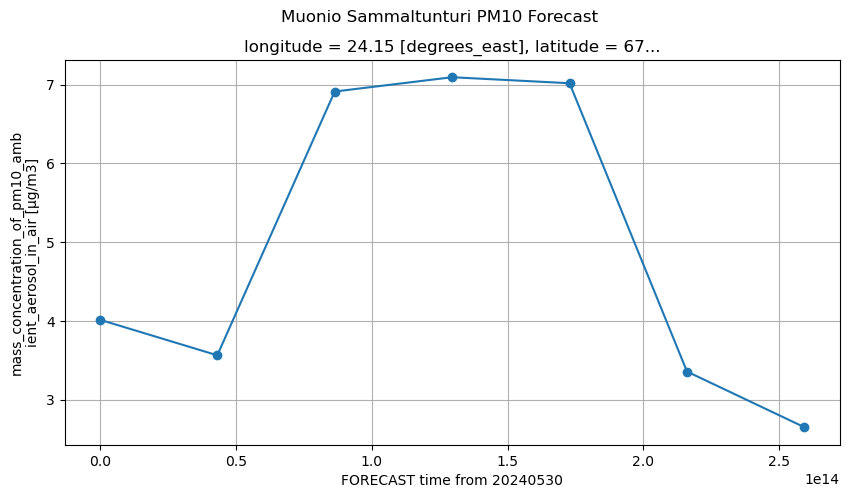

In [17]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.grid(True)
plt.suptitle('Muonio Sammaltunturi PM10 Forecast')
pm10_muonio.plot(ax=ax, marker='o')

We can plot the 2D time series of the pm10 concentration in the area of interest

In [18]:
time_index = pm10_forecast_lev0.indexes['time']
time_index

TimedeltaIndex(['0 days 00:00:00', '0 days 12:00:00', '1 days 00:00:00',
                '1 days 12:00:00', '2 days 00:00:00', '2 days 12:00:00',
                '3 days 00:00:00'],
               dtype='timedelta64[ns]', name='time', freq=None)

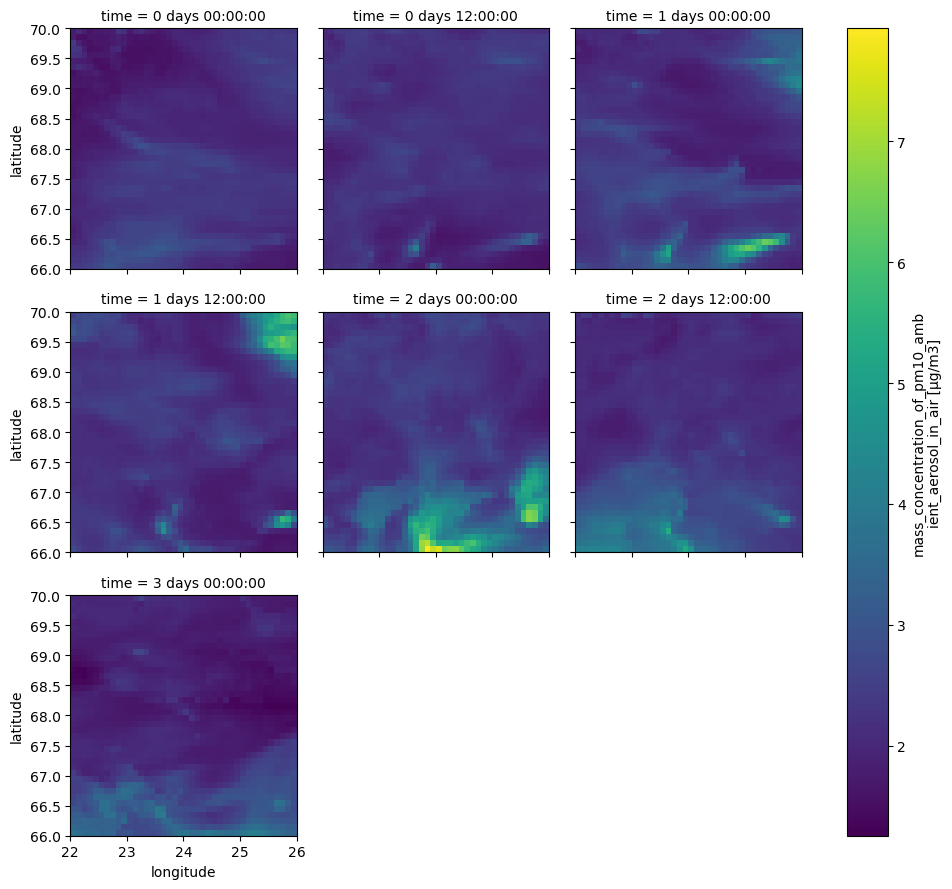

In [16]:
pm10_forecast_lev0.plot(x='longitude', y='latitude', col='time', col_wrap=3)

## Wind field
Wind field data, at 10 meters, is also available from CAMS. The dataset is [CAMS global atmospheric composition forecasts](https://ads.atmosphere.copernicus.eu/cdsapp#!/dataset/cams-global-atmospheric-composition-forecasts?tab=overview). Other data for the wind field is available from the Climte Change Service (C3S), the dataset is the [ERA5 hourly data on single levels from 1940 to present](https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-single-levels?tab=overview).  

In [22]:
wind_field_file_name = 'cams_wind_uv_10m_2024-05-30.netcdf_zip'
wind_field_file_path = data_path + wind_field_file_name 

In [23]:
c.retrieve(
    'cams-global-atmospheric-composition-forecasts',
    {
        'date': '2024-05-29/2024-05-29',
        'type': 'forecast',
        'format': 'netcdf_zip',
        'variable': [
            '10m_u_component_of_wind', '10m_v_component_of_wind',
        ],
        'time': '00:00',
        'leadtime_hour': [
            '0', '12', '24',
            '36', '48',
        ],
        'area': [
            70, 22, 66,
            26,
        ],
    },
    wind_field_file_path)

2024-05-30 10:37:09,044 INFO Welcome to the CDS
2024-05-30 10:37:09,045 INFO Sending request to https://ads.atmosphere.copernicus.eu/api/v2/resources/cams-global-atmospheric-composition-forecasts
2024-05-30 10:37:09,076 INFO Request is queued
2024-05-30 10:37:10,102 INFO Request is running
2024-05-30 10:37:11,629 INFO Request is completed
2024-05-30 10:37:11,632 INFO Downloading https://download-0002-ads-clone.copernicus-climate.eu/cache-compute-0002/cache/data9/adaptor.mars_constrained.internal-1717058231.200739-30280-5-9837860c-f59a-4eac-baf6-1aa4697dd521.zip to data/cams/cams_wind_uv_10m_2024-05-30.netcdf_zip (3.9K)
2024-05-30 10:37:13,176 INFO Download rate 2.5K/s


Result(content_length=4008,content_type=application/zip,location=https://download-0002-ads-clone.copernicus-climate.eu/cache-compute-0002/cache/data9/adaptor.mars_constrained.internal-1717058231.200739-30280-5-9837860c-f59a-4eac-baf6-1aa4697dd521.zip)

The downloaded data is zipped so it must be unzipped in a folder

In [26]:
import zipfile
with zipfile.ZipFile(wind_field_file_path, 'r') as zip_ref:
    zip_ref.extractall('data/cams/wind_field')

In [27]:
wind_ds = xr.open_dataset('data/cams/wind_field/data.nc')
wind_ds

<xarray.Dataset>
Dimensions:    (longitude: 11, latitude: 11, time: 5)
Coordinates:
  * longitude  (longitude) float32 22.0 22.4 22.8 23.2 ... 24.8 25.2 25.6 26.0
  * latitude   (latitude) float32 70.0 69.6 69.2 68.8 ... 67.2 66.8 66.4 66.0
  * time       (time) datetime64[ns] 2024-05-29 ... 2024-05-31
Data variables:
    v10        (time, latitude, longitude) float32 ...
    u10        (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2024-05-30 08:37:11 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

In [28]:
u10 = wind_ds['u10']
v10 = wind_ds['v10']

In [29]:
time_index = u10.indexes['time']
time_index[:2]

DatetimeIndex(['2024-05-29 00:00:00', '2024-05-29 12:00:00'], dtype='datetime64[ns]', name='time', freq=None)

In [36]:
u10_muonio = u10.sel(latitude=muonio_lat, longitude=muonio_lon, method='nearest')
v10_muonio = v10.sel(latitude=muonio_lat, longitude=muonio_lon, method='nearest')

Text(0.5, 1.0, 'Muonio (U and V wind components)')

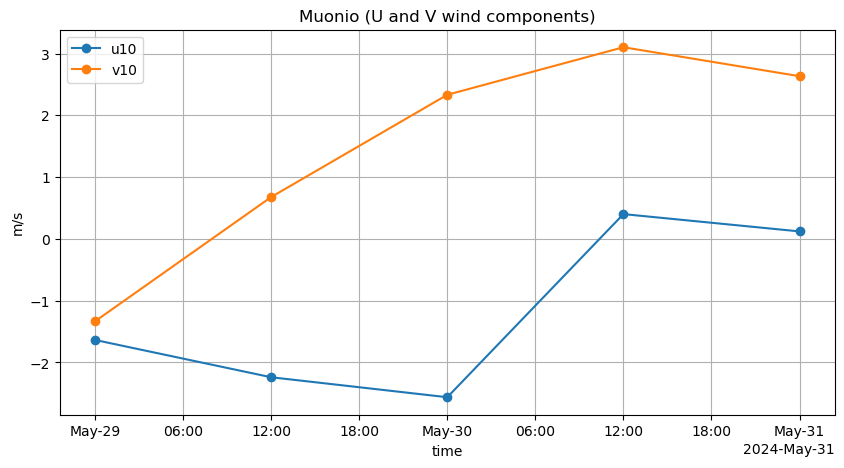

In [51]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.grid(True)
plt_u10 = u10_muonio.plot(ax=ax, marker='o', label='u10')
plt_v10 = v10_muonio.plot(ax=ax, marker='o', label='v10')
plt.legend(loc='upper left')
plt.ylabel('m/s')
plt.title('Muonio (U and V wind components)')

## Wind vector field
We select one day and time from the dataset for each wind component. The data contains a 2D array of the speed values of the wind component and two 1D arrays for the coordinates (longitude and latitude).

In [68]:
u10_t0 = u10.sel(time='2024-05-29T00:00:00')
v10_t0 = v10.sel(time='2024-05-29T00:00:00')
u10_t0.shape, v10_t0.shape

((11, 11), (11, 11))

In [94]:
Lat = u10_t0['latitude']
Lon = u10_t0['longitude']

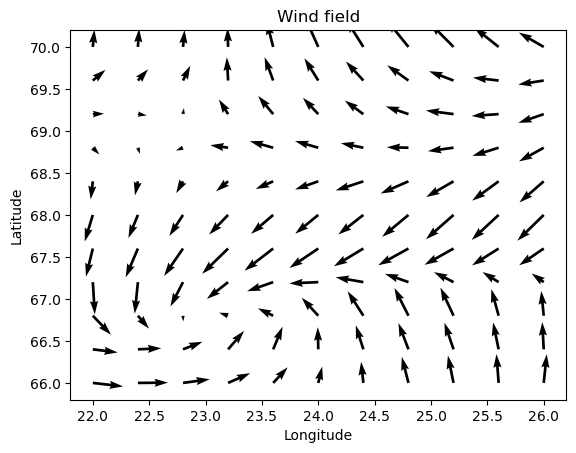

In [96]:
fig, ax = plt.subplots()
q = ax.quiver(Lon, Lat, u10_t0, v10_t0)
plt.title('Wind field')
plt.ylabel('Latitude')
plt.xlabel('Longitude')
plt.show()

In [53]:
w10_area_t0_squared = u10_area_t0.values * u10_area_t0.values + v10_area_t0.values * v10_area_t0.values 
w10_area_t0_squared.min(), w10_area_t0_squared.max()

(0.16561511, 6.849684)

In [54]:
w10_area_t0 = np.sqrt(w10_area_t0_squared)
w10_area_t0.min(), w10_area_t0.max()

(0.40695837, 2.6171901)

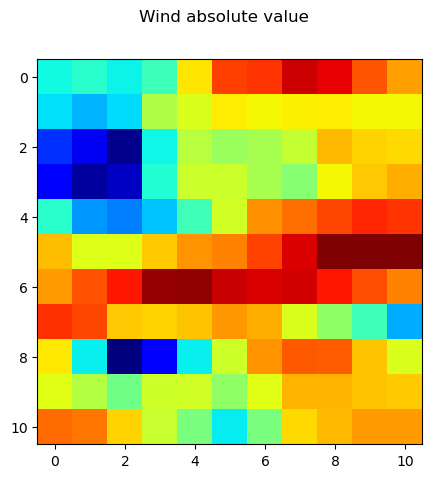

In [82]:
fig, ax = plt.subplots(figsize=(5,5))
plt.suptitle('Wind absolute value')
plt.imshow(w10_area_t0, cmap='jet')

Next step: use xarray or Matplotlib [quiver](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.quiver.html)